## 4.4 Simulating a GEDI waveform

In [1]:
from __future__ import print_function, division
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from run_start import *
from hips import hips2img, hips2ani, read_header
from scipy import constants
from IPython.display import HTML

In [2]:
from generate_camera_file import update_existing_camera

In [3]:
input_scene = 'obj/testScene.obj'

In [4]:
# here we can assume our scene units are ~metres, therefore we 
# need to convert our LiDAR pulse into m.

gedi_fwhm = 15
gedi_sigma = gedi_fwhm / (2 * np.sqrt(2 * np.log(2)))

L = 1e-9 * constants.c # speed of light m/ns
pl_ln = 60 * L # pulse length

boomLength = 400000 # height of ISS illumination (and camera) in m
groundRange = boomLength
footprint = 22 # diameter at exp(-2) of peak power (86% of energy)

psf_sd = np.exp(1.5) #Gaussian footprint PSF SD is 5.5 but librat needs me to scale it to the footprint...

update_existing_camera('light/gedi.lidar', 'light/large_footprint.lidar.gedi',
                       new_options={'lidar.pulseStart':pl_ln/2.0,
                                    'lidar.pulseForm':'gaussian',
                                    'lidar.pulseSD':gedi_sigma,
                                    'lidar.pulseLength':pl_ln,
                                    'lidar.pulseOPFile':'light/gedi_pulse.dat',
                                    'geometry.boomLength':boomLength,
                                    'geometry.idealArea':footprint*2,
                                    'samplingPattern.form':'gaussian',
                                    'samplingPattern.size':[5000, 5000],
                                    'samplingPattern.sd':[psf_sd, psf_sd],
                                    'samplingPattern.centre':[2500, 2500],
                                    'samplingPattern.OPImage':'light/gediGaussian.hips'})
                                    #,'samplingPattern.threshold':np.exp(-3)})

In [5]:
oname='output/gedi_footprint' # geometry.idealArea = footprint
hoc = 25 # height of canopy
diff_camera_toc = boomLength - hoc
binStart = diff_camera_toc * 2
binStep = 0.15
nBins = ((boomLength * 2) - binStart) / binStep + 60

update_existing_camera('camera/gedi.lidar', 'camera/large_footprint.lidar.gedi',oname=oname,
                       new_options={'geometry.idealArea':footprint*2,
                                    'geometry.boomLength':boomLength,
                                    'lidar.binStart':binStart,
                                    'lidar.binStep':binStep,
                                    'lidar.nBins':nBins})                                

In [6]:
# create a height map of the scene
cmd = 'echo 16 50 50 200 %i %i 1024 1024 1 output/gedi.height.hips | \
       start -RATtolerance %s' % (footprint*2,footprint*2,input_scene)
print(cmd)
if not os.path.exists('output/gedi.height.hips'):
    error = run_start(cmd)
else:
    error = False

echo 16 50 50 200 44 44 1024 1024 1 output/gedi.height.hips |        start -RATtolerance obj/testScene.obj


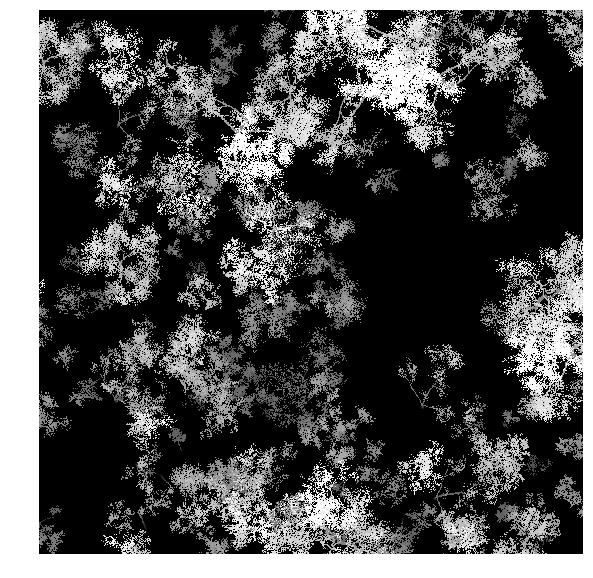

In [7]:
# and check the height image
if not error:
    hips2img('output/gedi.height.hips', order=[0])

In [16]:
# now we can run the simulation
cmd = 'echo 14 camera/large_footprint.lidar.gedi light/large_footprint.lidar.gedi | \
       start -RATm 1 -RATsensor_wavebands wb/gedi_waveband.dat %s' % (input_scene)
print(cmd)
error = run_start(cmd)   

echo 14 camera/large_footprint.lidar.gedi light/large_footprint.lidar.gedi |        start -RATm 1 -RATsensor_wavebands wb/gedi_waveband.dat obj/testScene.obj


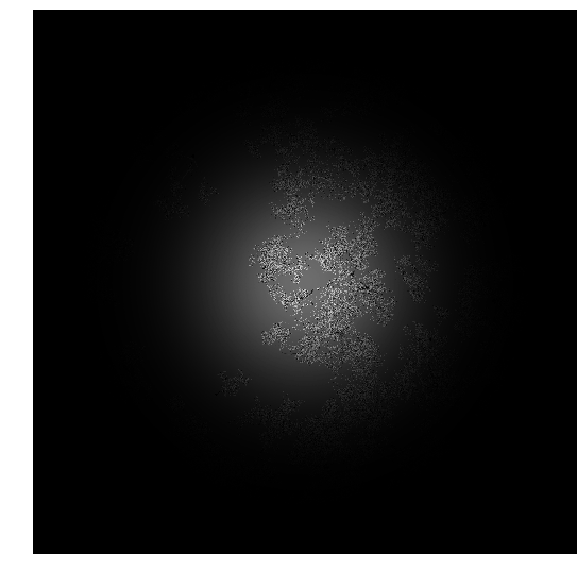

In [8]:
# and check the total reflectance image
if not error:
    ax = hips2img('{}.hips'.format(oname), stretch=False, order=None)

In [ ]:
# and save the animation
anim = hips2ani('{}.hips'.format(oname), 'output/gedi.height.hips', \
                    'output/gedi_footprint.dat.direct', groundRange)
HTML(anim.to_html5_video())
anim.save('gedi_waveform.mp4')
anim.save('gedi_waveform.gif', writer='imagemagick')